In [112]:
!pip3 install mpld3

     |████████████████████████████████| 888 kB 1.0 MB/s eta 0:00:01
  Created wheel for mpld3: filename=mpld3-0.5.2-py3-none-any.whl size=200617 sha256=323e91aee928ccaa8d49b53907f6dc6452e7f716220aca1675d7e8707cfb437e
  Stored in directory: /home/matthew/.cache/pip/wheels/11/af/f9/b3fc6166b9a794dcde7e64b183d48d495aa0f5e469d73ef385
Successfully built mpld3


In [1]:
%matplotlib inline
from datetime import timedelta

import numpy as np
from dateutil.parser import parse
from matplotlib import pyplot as plt

from coinbase_ml.common import constants as cc
from coinbase_ml.common.protos.environment_pb2 import InfoDictKey, RewardStrategy, Featurizer
from coinbase_ml.common.utils.ray_utils import get_actionizer
from coinbase_ml.fakebase.exchange import Exchange
from coinbase_ml.fakebase.types import OrderSide
from coinbase_ml.fakebase.protos.fakebase_pb2 import SimulationType
from coinbase_ml.trend_following import constants as c
from coinbase_ml.trend_following.experiment_configs import ema_crossover_staging

import mpld3
mpld3.enable_notebook()

/home/matthew/.virtualenvs/moonraker/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [104]:
exchange = Exchange(port=c.FAKEBASE_SERVER_PORT)

experiment_config = ema_crossover_staging()
actionizer_name = experiment_config["actionizer_name"]
actionizer_configs = {"fastWindowSize": 400, "slowWindowSize": 500}
end_dt = experiment_config["end_dt"]
featurizer = experiment_config["featurizer"]
initial_product_funds = experiment_config["initial_product_funds"]
initial_quote_funds = experiment_config["initial_quote_funds"]
# num_warmup_time_steps = experiment_config["num_warmup_time_steps"]
num_warmup_time_steps = 2880
reward_strategy = experiment_config["reward_strategy"]
# start_dt = experiment_config["start_dt"]
start_dt = "2020-11-18 00:00:00.00"
time_delta = experiment_config["time_delta"]

simulation_id = exchange.start(
    actionizer=get_actionizer(actionizer_name).proto_value,
    actionizer_configs=actionizer_configs,
    backup_to_cloud_storage=True,
    enable_progress_bar=True,
    end_dt=parse(end_dt),
    featurizer=Featurizer.Value(featurizer),
    initial_product_funds=cc.PRODUCT_ID.product_volume_type(initial_product_funds),
    initial_quote_funds=cc.PRODUCT_ID.quote_volume_type(initial_quote_funds),
    num_warmup_time_steps=num_warmup_time_steps,
    product_id=cc.PRODUCT_ID,
    reward_strategy=RewardStrategy.Value(reward_strategy),
    skip_database_query=True,
    simulation_type=SimulationType.evaluation,
    snapshot_buffer_size=1,
    start_dt=parse(start_dt),
    time_delta=timedelta(seconds=time_delta),
).simulation_id

account = exchange.account(simulation_id)

In [105]:
ema_fast = []
ema_slow = []
mid_price = []
portfolio_value = []
interval_end_times = []
exchange.reset(simulation_id)
while not exchange.finished(simulation_id):
    exchange.step(simulation_id, actor_output=np.array([]))
    interval_end_time = parse(exchange.simulation_metadata(simulation_id).simulation_info.exchangeInfo.intervalEndTime.replace("Z", ""))
    interval_end_times.append(interval_end_time)
    actionizer_state = exchange.simulation_metadata(simulation_id).simulation_info.observation.info.actionizerState
    ema_fast.append(actionizer_state["emaFast"])
    ema_slow.append(actionizer_state["emaSlow"])
    mid_price.append(exchange.info_dict(simulation_id)[InfoDictKey.Name(InfoDictKey.midPrice)])
    portfolio_value.append(exchange.info_dict(simulation_id)[InfoDictKey.Name(InfoDictKey.portfolioValue)])

In [106]:
initial_portfolio_value = float(initial_quote_funds)
roi = [(p - initial_portfolio_value) / initial_portfolio_value for p in portfolio_value]

initial_mid_price = float(mid_price[0])
returns = [(p - initial_mid_price) / initial_mid_price for p in mid_price]

In [107]:
buy_orders = []
sell_orders = []
for order in account.orders.values():        
    i = interval_end_times.index(order.time)
    if order.side == OrderSide.buy:
        buy_orders.append((order.time, ema_fast[i], roi[i], returns[i]))
    else:
        sell_orders.append((order.time, ema_fast[i], roi[i], returns[i]))

Text(0.5, 0, 'timestep')

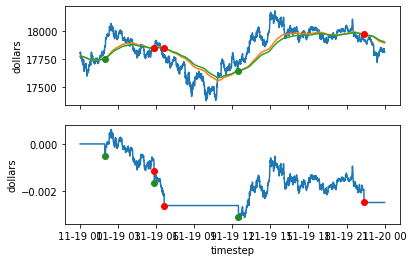

In [108]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
axs[0].plot(interval_end_times, mid_price, label="mid_price")
axs[0].plot(interval_end_times, ema_fast, label="ema_fast")
axs[0].plot(interval_end_times, ema_slow, label="ema_slow")
axs[0].plot(
    [i[0] for i in buy_orders], 
    [i[1] for i in buy_orders],
    color="forestgreen",
    label="buy_order",
    marker="o", 
    linestyle="None")
axs[0].plot(
    [i[0] for i in sell_orders], 
    [i[1] for i in sell_orders],
    color="red",
    label="sell_order",
    marker="o", 
    linestyle="None")

axs[1].plot(interval_end_times, roi, label="roi")
axs[1].plot(
    [i[0] for i in buy_orders], 
    [i[2] for i in buy_orders],
    color="forestgreen",
    label="buy_order",
    marker="o", 
    linestyle="None")
axs[1].plot(
    [i[0] for i in sell_orders], 
    [i[2] for i in sell_orders], 
    color="red",
    label="sell_order",
    marker="o", 
    linestyle="None")

axs[0].set_ylabel("dollars")
axs[1].set_ylabel("dollars")
axs[1].set_xlabel("timestep")
# axs[0].legend()
# axs[1].legend()

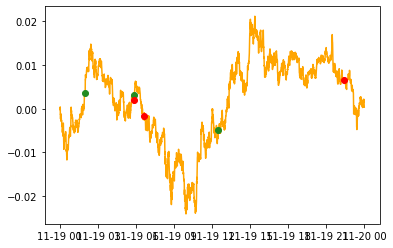

In [109]:
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
axs.plot(
    interval_end_times,
    returns,
    color="orange"
)
axs.plot(
    [i[0] for i in buy_orders], 
    [i[3] for i in buy_orders],
    color="forestgreen",
    label="buy_order",
    marker="o", 
    linestyle="None")
axs.plot(
    [i[0] for i in sell_orders], 
    [i[3] for i in sell_orders],
    color="red",
    label="sell_order",
    marker="o", 
    linestyle="None")